# **Chap9：现代集成学习方法**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
from sklearn.utils import resample
from copy import deepcopy
import seaborn as sns
colors = sns.palettes.color_palette("muted")

本章介绍三种**集成学习**（**ensemble model**）方法，包括：
* 梯度提升变种：**XGBoost**
* 梯度提升变种：**LightGBM**
* **Stacking**  

它们是目前人们使用最多，经过实践检验性能最优的方法，在处理大部分机器学习问题时，人们都会首先考虑尝试这几种方法

由于**XGBoost和LightGBM更多是工程上对梯度提升算法的进一步改造和优化**，本质上与梯度提升方法没有太大区别，我们**仅介绍模型的改进思想**，**具体的实现是工程问题而非机器学习算法问题**，更重要的是学会正确使用这些算法

## **1 XBGoost**

### **1.1 梯度提升方法总结**

在进一步介绍XGBoost之前，我们先对**梯度提升算法**（**Gradient Boosting**）的优缺点做简单总结和对比

**(1) 优点**

* 采用**梯度下降**思想，前向分步算法的每次迭代拟合当前损失函数的”残差“（**负梯度**），能够处理更为一般损失函数下的决策问题
    * 例如软件包中经常提供**中位数/绝对值损失**，**Huber损失**，**交叉熵损失**等
* 采用**稳健损失**（例如中位数损失替换平方损失）后的梯度提升模型，**对异常分布数据的鲁棒性非常强**
* Boosting算法给出的加法模型**不需要基学习器有很强的拟合能力**，**整体模型就能拥有很强的非线性学习能力**
* 通常情况下，**当维度不太高**，即 $N > p$ 时，梯度提升方法拥**有很高的预测精度**
* 可以**通过Shrinkage和随机采样**对模型进行**正则化**，减少**过拟合**：
    * Shrinkage引入一个收缩系数 $\eta < 1$ 来减小每一个基学习器在最终预测中的贡献，让更多的基学习器有话语权
    * 随机采样在每个基学习器训练时，对样本进行随机采样，同时对参与训练的特征进行采样，减少基学习器之间的相关性

**(2) 不足**

* 梯度提升**只利用了损失函数的一阶导数信息**，没有利用损失函数的**更高阶导数信息**，而更高阶导数虽然对目标函数提出了更高的可导性要求，但在函数最优化时往往更有效
* 梯度提升方法**没有讨论任何基学习器模型复杂度的问题**，模型正则化的调节需要人们凭借经验”手动“完成
* **软件包中只支持CART树作为基学习器**，不支持其他学习器（例如逻辑回归）
* **软件包只支持有限的损失函数**，即编写软件包时所提供的几种，在使用时**不支持自定义损失函数**
* **高纬数据**（$p$ 很大）时，会带来**巨大的计算问题**，是的模型的训练缓慢甚至不可行 
* 基学习器CART树在结点分裂时采用**遍历法**（遍历所有特征、遍历切分点），这一过程**非常耗时**
* 作为Boosting算法，当前算法包没有实现**并行化**加速

### **1.2 XGBoost模型思想**

XGBoost即**Extreme Gradient Boosting**算法的简称，简单来说，它是**基于梯度提升模型**，针对以上各种不足所提出一种**工程化改进**，改进后的算法具有了**分布式特性**，这让XGBoost也成为了工业内首选的机器学习模型之一

#### **1.2.1 带有正则化的损失函数**

回顾梯度提升方法的损失函数及优化目标：

$$
\{\alpha_b^*,\gamma_b^*\}_{b=1}^{B} = \mathop{\arg\min}\limits_{\alpha_b\in\mathbb{R},\gamma_b\in\Theta} \sum_{i=1}^{N} L\left( y_i,\sum_{b=1}^{B}\alpha_b G_b(x;\gamma_b) \right)
$$

其中，$L(y,f(x))$ 是模型决策所使用的损失函数

从**偏差方差分析**的角度：
$$
\text{err}(x) = bias^2(x) + var(x) + \varepsilon^2
$$
上述优化目标**只能体现模型对数据拟合能力的不断增强，即减小偏差**，**没有体现对模型复杂度的控制**，即**减小方差**

回顾**Ridge**和**Lasso**，模型的损失函数被写为：

$$
\begin{array}{ll}
\text{Ridge：} & \displaystyle{ \min \left( \frac{1}{N}\sum_{i=1}^{N}(y_i - X_i\beta)^2 + \lambda \|\beta\|_2^2\right) }\\
\text{Lasso：} & \displaystyle{ \min \left(\frac{1}{N}\sum_{i=1}^{N}(y_i - X_i\beta)^2 + \lambda \|\beta\|_1\right) }\\
\end{array}
$$

其中，$\lambda \|\beta\|_2^2$ 和 $\lambda \|\beta\|_1$ 就是模型对回归系数的**惩罚项**，**起到正则化的作用**，因此也称为**正则化项**

因此，对于一般的机器学习模型，目标函数通常写为**损失函数+正则化项**的形式：
$$
\mathcal{L}(\theta) = L(\theta) + \Omega(\theta)
$$

* 损失函数表示模型**拟合数据的情况**，即控制**偏差**
* 正则项惩罚复杂的模型，鼓励简单的模型，即控制**方差**

下面的说明**以回归问题为例**，我们仍然**以CART树作为基学习器**，最终的加法模型表示为：

$$
f(x) = \sum_{b=1}^{B}G_b(x;\gamma_b) = \sum_{b=1}^{B}{\left(  \sum_{j=1}^{J_b} c_{b,j} \mathbb{I}(x\in R_{b,j}) \right)}
$$

其中，$R_{b,j}$ 表示第 $b$ 棵树的第 $j$ 个叶子区域，$c_{b,j}$ 是对应的该叶子区域的预测值

XGBoost在损失函数基础上考虑了**叶结点个数**和**每个叶子的输出值**的正则化：

$$
\Omega(G_b) = \tau\cdot J_b + \frac{1}{2}\lambda \|c_b\|_2^2 = \tau\cdot J_b + \frac{1}{2}\lambda \sum_{j=1}^{J_b} c_{b,j}^2
$$

其中：
* $J_b$ 代表**叶结点个数**，它是对**决策树模型整体复杂度的惩罚**，叶结点越多，模型越复杂，就越容易过拟合
* $\lambda \|c_b\|_2^2$ 基于**Ridge**思想，目的是**让叶结点的输出值** $c_{b,j}$ **尽可能平滑**，从而避免过度拟合
* $\tau > 0,\lambda > 0$ 是正则化超参数，用于控制惩罚的权重

因此，XGBoost对于决策函数 $f$：
$$
f(x) = \sum_{b=1}^{B}G_b(x;\gamma_b)
$$
的总体的目标函数可以写作：

$$
\mathcal{L}(f) = \sum_{i=1}^{N} L(y_i,f(x_i)) + \sum_{b=1}^{B}\Omega(G_b) = \sum_{i=1}^{N} L\left( y_i,\sum_{b=1}^{B}G_b(x;\gamma_b) \right) + \sum_{b=1}^{B}\Omega(G_b)
$$

这样，**XGBoost模型直接从目标函数上考虑了每个基学习器的模型复杂度，而无需我们手动预先设置基学习器超参数以控制复杂度**

**求解XGBoost模型需要极小化** $\mathcal{L}$，注意到，我们**仍然可以使用前向分步算法求解**

假设在算法迭代的第 $b$ 轮，我们已经获得决策函数 $f_{b-1}(x)$：
$$
f_{b-1}(x) = \sum_{k=1}^{b-1}G_k(x;\gamma_k)
$$

此时，我们求解第 $b$ 个基学习器的优化问题：

$$
\begin{array}{rcl}
\gamma_b & = & \displaystyle{ \mathop{\arg\min}\limits_{\gamma\in\Theta} \sum_{i=1}^{N} L\left( y_i,f_{b-1}(x_i) +  G_b(x_i;\gamma_b) \right) + \Omega(G_b) }\\
& = & \displaystyle{ \mathop{\arg\min}\limits_{\gamma\in\Theta} \sum_{i=1}^{N} L\left( y_i,f_{b-1}(x_i) +  G_b(x_i;\gamma_b) \right) + \tau J_b + \frac{1}{2}\lambda \|c_b\|_2^2 }\\
\end{array}
$$

可以看到。第 $b$ 个基学习器的构建不影响前 $b-1$ 基学习器，因此**正则化项也只需要考虑** $\omega(G_b)$

回顾，在没有正则化项的时候，我们可以采用梯度提升相同的思想，**按照梯度下降的方法，用基学习器拟合负梯度**

#### **1.2.2 使用二阶梯度求解优化问题**

梯度下降采用一种**最快下降速度**的思想，导出**负梯度方向是极小化问题中函数值下降速度最快的方向**，而**如果目标函数的二阶导数信息可用**，使用二阶导数的方法（即**牛顿类方法**），**收敛速度的精度通常更高**

理解二阶导数带来的优势并不困难，假设 $f(x),x\in \mathbb{R}^p $ 是我们优化的目标函数，我们要求 $f(x)$ 的极小值：
$$
\min_{x\in\mathbb{R}^p} f(x)
$$

* **梯度下降**法在当前点 $x_k$ 做 $f(x)$ 的**一阶Tayler近似**
    $$
    f(x) = f(x_k) + \nabla f(x_k)^T(x - x_k)
    $$
    以迭代到下一个点 $x_{k+1}$，这**等价于用一次平面来逼近曲面** $f(x)$，优点是计算简单，缺点是**逼近精度有限**
* 使用**二阶导数**的**牛顿类方法**当前点 $x_k$ 做 $f(x)$ 的**二阶Tayler近似**
    $$
    f(x) = f(x_k) + \nabla f(x_k)^T(x - x_k) + \frac{1}{2}(x - x_k)^T\nabla^2 f(x_k) (x - x_k)
    $$
    以迭代到下一个点 $x_{k+1}$，这**等价于用二次平面来逼近曲面** $f(x)$，优点是**逼近精度高**，缺点是**需要付出包括二阶导数和黑塞矩阵** $\nabla^2 f(x)\in\mathbb{R}^{p\times p}$ 在内的**额外的计算代价**

因此，**使用了高阶导数信息的优化算法，收敛速度和求解精度通常更高**

我们具体来看**牛顿类方法的优化思想**，设 $g_k = \nabla f(x_k), H_k = \nabla^2 f(x_k)$ 分别表示函数在 $x_k$ 处的梯度和黑塞矩阵，则二阶近似：

$$
f(x) = f(x_k) + g_k^T(x - x_k) + \frac{1}{2}(x - x_k)^T H_k(x - x_k)
$$

假设要极小化 $f(x)$，则上式是关于 $x\in\mathbb{R}^p$ 的二次函数，令导数等于0，可以得到极值点为： 

$$
\nabla f(x^*) = g_k + H_k(x^*-x_k) = 0 \quad\Rightarrow\quad x^* = x_k - H_k^{-1}g_k
$$

因此，**牛顿类方法的下一步迭代公式**为：
$$
x_{k+1} = x_k - H_k^{-1}g_k, \quad k=0,1,\cdots
$$
其中，$H_k^{-1}g_k$ 被称为**牛顿方向**

**回到XGBoost**，在考虑第 $b$ 个基学习器的求解时，待优化的目标函数为：

$$
\min_{\gamma_b} \mathcal{L_b} = \min_{\gamma_b} \left( \sum_{i=1}^{N} L\left( y_i,f_{b-1}(x_i) +  G_b(x_i;\gamma_b) \right) + \Omega(G_b) \right)
$$

对目标函数在 $f=f_b{-1}$ 处进行二阶Tayler近似，得到：

$$
\mathcal{L_b} = \sum_{i=1}^{N} \big\{ L\left(y_i,f_{b-1}(x_i)\right) + g_{b,i} G_b(x_i;\gamma_b) + \frac{1}{2}h_{b,i}G_b^2(x_i;\gamma_b) \big\} + \Omega(G_b)
$$

其中，$g_{b,i},H_{b,i}$ 分别表示**损失函数在每个样本上的一阶和二阶偏导数**：

$$
g_{b,i} = \frac{\partial L(y_i,f(x_i))}{\partial f}\big|_{f=f_{b-1}},\quad h_{b,i} = \frac{\partial^2 L(y_i,f(x_i))}{\partial f^2}\big|_{f=f_{b-1}},\quad i=1,\cdots,N
$$

注意，下面的量在目标函数表达式中，均与 $G_b(x)$ 无关，它们可以视为优化的常数：
$$
f_{b-1}(x_i),\quad L(y_i,f_{b-1}(x_i)),\quad g_{b,i},\quad h_{b,i},\quad i=1,\cdots,N
$$

**丢弃无关常数**，目标函数可以简写为：

$$
\mathcal{L_b} = \sum_{i=1}^{N} \big\{ g_{b,i} G_b(x_i;\gamma_b) + \frac{1}{2}h_{b,i}G_b^2(x_i;\gamma_b) \big\} + \Omega(G_b)
$$

我们将树 $G_b(x)$ 的结构代入，得到：

$$
\begin{array}{rcl}
\mathcal{L}_b & = & \displaystyle{ \sum_{i=1}^{N} \big\{ g_{b,i} \left(\sum_{j=1}^{J_b}c_{b,j} \mathbb{I}(x\in R_{b,j})\right) + \frac{1}{2}h_{b,i}\left(\sum_{j=1}^{J_b}c_{b,j}^2 \mathbb{I}(x\in R_{b,j})\right)  \big\} + \tau J_b + \frac{1}{2}\lambda \sum_{j=1}^{J_b}c_{b,j}^2 } \\
& = & \displaystyle{ \sum_{j=1}^{J_b}\left[ \left(\sum_{x\in R_{b,j}}{g_{b,i}} \right) c_{b,j} + \frac{1}{2}\left( \sum_{x\in R_{b,j}} h_{b,i} + \lambda \right)c_{b,j}^2 \right] + \tau J_b } \\
& = & \displaystyle{ \sum_{j=1}^{J_b}\left[ G_{b,j} c_{b,j} + \frac{1}{2}\left( H_{b,j} + \lambda \right)c_{b,j}^2 \right] + \tau J_b } \\
\end{array}
$$

其中，$G_{b,j}.H_{b,j}$ 分别各叶子结点上一阶和二阶导数的统计量：

$$
G_{b,j} = \sum_{x\in R_{b,j}}{g_{b,i}},\quad H_{b,j} = \sum_{x\in R_{b,j}} h_{b,i},\quad j=1,\cdots,J_b
$$

$\mathcal{L_b}$ 对 $c_{b,j}$ 求导，令导数等于0，可以**得到每个叶子结点上的最优预测为**：

$$
c_{b,j}^* = -\frac{G_{b,j}}{H_{b,j}+\lambda}
$$

代入目标函数，可以得到**给定决策树的划分** $\mathcal{R}=\{R_{b,j}\}_{j=1}^{J_b}$ 时，**最优目标函数值**为：

$$
\tilde{\mathcal{L}}_b(\mathcal{R}) = -\frac{1}{2}\sum_{j=1}^{J_b}\frac{G_{b,j}^2}{H_{b,j}+\lambda} + \tau J_b
$$

$\tilde{\mathcal{L}}_b(\mathcal{R})$ 被称为结构 $\mathcal{R}$ 的**结构分数**，用于**综合衡量模型拟合效果和模型复杂度，它的值越小越好**，和式中的每一项即为每个结点 $j$ 处的结构分数

**基于结构分数，我们就可以制定决策树的分裂规则**了，分裂的核心思想不变，我们需要扫描**所有可分裂特征** $k$，**及该特征的切分点** $s$，寻找**最优的分裂对** $(k,s)$，具体的分裂算法叙述如下：

**(Algo) XGBoost决策树分裂算法**：
* (1) 给定决策树的某个结点 $n$，计算**该结点处的结构分数**：
$$
\tilde{\mathcal{L}}(n) = -\frac{1}{2} \frac{ \left( \sum_{x_i\in n} g_{b,i}\right)^2 }{ \sum_{x_i\in n} h_{b,i} + \lambda } + \tau
$$
* (2) 依次选择切分特征 $k$，及该特征的切分点 $s$，构成切分对 $(k,s)$
    * (2.1) 按照切分对 $(k,s)$ **将该结点处的样本划分到左右两个子结点** $n_L,n_R$：
        * 如果特征 $k$ 是数值型特征：
        $$
        n_L = \{x\in n|x^{(k)} <= s\},\quad n_R = \{x\in n|x^{(k)} > s\}
        $$
        * 如果特征 $k$ 是类别型特征：
        $$
        n_L = \{x\in n|x^{(k)} = s\},\quad n_R = \{x\in n|x^{(k)} \ne s\}
        $$
    * (2.2) 切分后，分别**计算左右两个子结点处的结构分数**及子结构的结构分数和：
    $$
    \tilde{\mathcal{L}}(n_L) = -\frac{1}{2} \frac{ \left( \sum_{x_i\in n_L} g_{b,i}\right)^2 }{ \sum_{x_i\in n_L} h_{b,i} + \lambda } + \tau \\
    \tilde{\mathcal{L}}(n_R) = -\frac{1}{2} \frac{ \left( \sum_{x_i\in n_R} g_{b,i}\right)^2 }{ \sum_{x_i\in n_R} h_{b,i} + \lambda } + \tau \\
    \tilde{\mathcal{L}}(n_L) + \tilde{\mathcal{L}}(n_R) = -\frac{1}{2} \frac{ \left( \sum_{x_i\in n_L} g_{b,i}\right)^2 }{ \sum_{x_i\in n_L} h_{b,i} + \lambda } -\frac{1}{2} \frac{ \left( \sum_{x_i\in n_R} g_{b,i}\right)^2 }{ \sum_{x_i\in n_R} h_{b,i} + \lambda } + 2\tau
    $$
    * (2.3) 计算该分裂 $(k,s)$ 带来的增益 $\text{Gain}(k,s)$：
        $$
        \text{Gain}(k,s) = \tilde{\mathcal{L}}(n) - [\tilde{\mathcal{L}}(n_L) + \tilde{\mathcal{L}}(n_R)]
        $$
        注意，$\text{Gain}(k,s)$ **可能是负值**，这表明**分裂只会带来增益的下降**，此时不再进行分裂，实际中，会使用某个阈值参数 $\varepsilon > 0$，只有当 $\text{Gain}(k,s) > \varepsilon$ 时，才考虑这个分裂 $(k,s)$
    * (2.4) 如果分裂 $(k,s)$ **能够带来可信的增益，就保存这次分裂信息**
* (3) 决定最终的分裂方案
    * (3.1) 如果**可信增益分裂的集合不为空**，从中选择**分裂增益最大的组合** $(k^*,s^*)$ 作为最优分裂决策，然后分裂该结点
    * (3.2) 如果**可信增益分裂的集合为空集**，意味着**没有进一步分裂该结点的意义**，停止分裂

上述的分裂决策规则，在考虑子树结构复杂度的同时，也体现了**预剪枝**思想

#### **1.2.3 近似分裂算法**

结构分数导出的增益确定了XGBoost算法的分裂规则，但**在真正的算法执行中，会遇到计算复杂度过高的问题**

对大多数的梯度提升算法，上面介绍的贪心的结点分裂算法是**精确贪心算法**（**Exact Greedy**），这种算法在考虑切分对 $(k,s)$ 时，会顺序选择每一个切分特征 $k$，和特征 $x^{(k)}$ 的每一个可能的切分值 $s$，我们将精确贪心算法描述如下：

**(Algo) 结点分裂的精确贪心算法（Exact Greedy）**：
* **输入**：当掐结点 $n$，当前轮次 $b$ 和前 $b-1$ 步得到的模型 $f_{b-1}$，特征维度 $p$，样本量为 $N$，惩罚权重 $\lambda,\tau>0$
* **输出**：分裂后的结点 $n_L,n_R$
* **算法流程**：
    * (1) 初始化：
    $$ 
    \text{Gain} = 0,\quad \text{G} = \sum_{x_i\in n} g_{b,i}, \quad \text{H} = \sum_{x_i\in n} h_{b,i}
    $$
    * (2) **依次选择** $k=1,2,\cdots,p$：
        * (2.1) 初始化：$G_L = 0,H_L = 0$
        * (2.2) 将结点 $n$ 上的数据**根据特征** $x^{(k)}$ **进行排序**
        * (2.3) **依次选择** $j=1,2,\cdots,N$：
            * (2.3.1) 计算 $G_L, G_R, H_L, H_R$：
            $$
            G_L = G_L + g_{b,j},\quad H_L = H_L + h_{b,j}\\
            G_R = G - G_L,\quad H_R = H_R - H_L\\
            $$
            上面的计算，等价于考虑了切分对 $(k,x_j^{(k)})$
            * (2.3.2) 计算增益：
            $$
            \text{Gain} = \max\big\{ \text{Gain}, \frac{1}{2} \left[\frac{G_L^2}{H_L+\lambda} + \frac{G_R^2}{H_R+\lambda} - \frac{G^2}{H + \lambda}\right] - \tau  \big\}
            $$
    * (3) 让结点 $n$ 在最大 $\text{Gain}$ 对应的切分对 $(k,s)$ 上分裂

上述算法会带来极高的计算复杂度：
* 一方面，假设特征数量为 $p$，样本量为 $N$，则完成一轮扫描所需要的复杂度为 $\mathcal{O}(pN)$（**依次选择每一个特征，和该特征上每一个可能的取值**），这在 $p$ 和 $N$ 较大的时候都不可行
* 另一方面，在考虑某个切分对 $(k,s)$ 时，我们还**需要将样本根据特征** $x^{(k)}$ **进行排序**，然后根据切分点 $s$ 比较大小，将样本划分到左右结点，**排序操作同样需要花费大量时间**
* **排序时我们通常需要将样本导入内存**，这在 $p,N$ 很大时给硬件带来了很大压力，容易**出现内存紧张的问题**

因此，我们希望减少结点分裂的计算量，提出一种**近似算法**，在**降低运算成本的同时，不要损耗过多的性能**

基本的想法是，对每个变量 $k$，**仅挑选少数几个切分点** $S_k=\{s_{k,1},\cdots,s_{k,l}\}$ 进行扫描：
$$
s_{k,1} \leq s_{k,2}\leq \cdots \leq s_{k,l}
$$

自然地，第一个问题是，如何确定切分点集合 $S_k$？一种直观的想法是**抽取分位数**

**抽取分位数本质上是对特征** $x^{(k)}$ 的分布进行等分，从而利用分位点，但XGBoost在此基础上更进一步，它使用了**加权分位点**，加权分位点的思想相当于对特征 $x^{(k)}$ 的取值进行了**重要性排序**，根据排序结果，再**选出值得尝试的切分点**

回顾我们对于第 $b$ 个基学习器的目标函数：

$$
\mathcal{L_b} = \sum_{i=1}^{N} \big\{ g_{b,i} G_b(x_i;\gamma_b) + \frac{1}{2}h_{b,i}G_b^2(x_i;\gamma_b) \big\} + \Omega(G_b)
$$

注意 $\{h_{b,i}\}_{i=1}^{N}$ 是与优化无关的常数，可以将上式变形：

$$
\begin{array}{rcl}
\mathcal{L}_b & = & \displaystyle{ \sum_{i=1}^{N} \big\{ g_{b,i} G_b(x_i;\gamma_b) + \frac{1}{2}h_{b,i}G_b^2(x_i;\gamma_b) \big\} + \Omega(G_b) }\\
& = & \displaystyle{ \sum_{i=1}^{N} \frac{1}{2}h_{b,i}\big\{ 2\frac{g_{b,i}}{h_{b,i}} G_b(x_i;\gamma_b) + G_b^2(x_i;\gamma_b) \big\} + \Omega(G_b) }\\
& = & \displaystyle{ \sum_{i=1}^{N} \frac{1}{2}h_{b,i}\big\{\left(\frac{g_{b,i}}{h_{b,i}} \right)^2 + 2\frac{g_{b,i}}{h_{b,i}} G_b(x_i;\gamma_b) + G_b^2(x_i;\gamma_b) - \left(\frac{g_{b,i}}{h_{b,i}} \right)^2 \big\} + \Omega(G_b) }\\
& = & \displaystyle{ \frac{1}{2}\sum_{i=1}^{N} h_{b,i}\left( G_b(x_i;\gamma_b) - \left[-\frac{g_{b,i}}{h_{b,i}}\right]\right)^2 + \Omega(G_b) + C }\\
\end{array}
$$

配方后，可以看到目标函数是一个**以** $\{h_{b,i}\}_{i=1}^{N}$ **为权重的平方损失**，**基学习器** $G_b(x;\gamma_b)$ **拟合的目标是牛顿方向**：
$$
\big\{ -\frac{g_{b,i}}{h_{b,i}} \big\}_{i=1}^{N}
$$

因此，样本 $(x_i,y_i)$ 对于目标函数的贡献度等于其二阶导数 $h_{b,i}$，我们可以**根据** $\{h_{b,i}\}_{i=1}^{N}$ **来完成特征的重要性排序**

**XGBoost给出了如下的特征重要性排名函数** $r_k(z) : \mathbb{R}\to [0,1]$，假设**损失函数是凸函数**，则 $h_{b,i} > 0$，对于某个节点 $n$，某个特征 $k$，任意 $z\in\mathbb{R}$：

$$
r_k(z) = \frac{1}{\sum_{x_i \in n} h_{b,i}} \sum_{x_i\in n, x_i^{(k)} < z} h_{b,i}
$$

可以看到 $r_k(z)$ 的分子是所有第 $k$ 个特征 $x^{(k)} < z$ 的样本对应的 $h_{b,i}$ 的和

之后，选择某个**近似因子** $\varepsilon > 0$，寻找**尽可能等间隔的切分点** $S_k=\{s_{k,1}\cdots,s_{k,l}\}$ 使得：
$$
|r_k(s_{k,j}) - r_k(s_{k,j+1})| < \varepsilon, \forall j\quad s_{k,1} = \min_i x_i^{(k)},s_{k,l} = \max_i x_i^{(k)}
$$

简单来说，即**两个切分点的间隔要保证小于** $\varepsilon$，同时**两个切分点包含的样本数量要尽可能多**，根据以上准则，**大约要挑选出** $1/\varepsilon$ **个切分点**

因此，$\varepsilon$ 控制了切分点挑选的**近似程度**，所以称为**近似因子**，$\varepsilon$ **越小，近似程度越高，挑选的切分点越多，算法计算复杂度也就越高**

下图以9个样本的特征取值 $x_i^{(k)}$、二阶导数 $h_{b,i}$ 及其重要性排名结果 $r_k(z)$ 为示例：

<img src="./source/Chap9/加权分位数.png" width=800>

可以看到，二阶导数的总和等于 $\sum_{i} h_{b,i} = 2.0$，**如果取** $\varepsilon=1/4$，**则9个样本将会被划分为如上的4组**

**基于加权分位数**，下面我们来叙述XGBoost在处理决策树分裂时的**近似分裂算法**，算法本质和**精确贪心算法**没有区别，只是切分点的选择上使用了加权分位数法

**(Algo) 结点分裂的近似分裂算法（Approximate Split）**：
* **输入**：当掐结点 $n$，当前轮次 $b$ 和前 $b-1$ 步得到的模型 $f_{b-1}$，特征维度 $p$，样本量为 $N$，近似因子 $\varepsilon$，惩罚权重 $\lambda,\tau>0$
* **输出**：分裂后的结点 $n_L,n_R$
* **算法流程**：
    * (1) **依次选择每个特征** $k=1,2,\cdots,p$：
        * (1.1) 利用二阶导数和函数 $r_k(z)$，为特征 $k$ 准备好**切分点** $S_k=\{s_{k,1},\cdots,s_{k,l}\}$，这有两种方案可选：
            * **全局方案（global）**：在每棵树，即每个基学习器训练前计算出 $S_k$
            * **局部方案（local）**：在树的每个结点，即每次分裂前计算出 $S_k$
    * (2) **依次选择每个特征** $k=1,2,\cdots,p$：
        * (2.1) **依次选择切分点集** $S_k$ **中的每个点** $v=2,3,\cdots,l$，计算：
        $$
        G_{k,v} = \sum_{x_i\in n, s_{k,v-1}\leq x_i^{(k)} < s_{k,v}} g_{b,i},\quad H_{k,v} = \sum_{x_i\in n, s_{k,v-1}\leq x_i^{(k)} < s_{k,v}} h_{b,i}
        $$
    * (3) 类似**精确贪心算法**中的步骤，寻找到最大增益 $\text{Gain}$，从而确定最优分裂

针对两种 $S_k$ 的计算方法，我们做简单的补充说明：
* **全局方案（global）**：我们在**一棵树的生成之前**，就已经计算好每个特征的分裂点 $S_k$，并且**在整个树的生成过程当中，用的都是一开始计算的分裂点**，这也就代表了，使用**全局策略的开销更低**，但**如果分裂点不够多的话，会牺牲部分性能**
* **局部方案（local）**：在**分裂时，对每一个结点所包含的样本，重新计算其所有特征的分裂点** $S_k$，在一棵树分裂的时候，**样本会逐渐被划分到不同的结点中**，因此**每个结点所包含的样本，以及这些样本有的特征取值是不一样的**，因此对每个结点重新计算分裂点**可以更好保证模型性能**，相当于是**因地制宜**。但显然**局部方法的计算开销更大**，使用**局部方法分裂点数目不用太多**，即近似因子 $\varepsilon$ 可以取稍大一些，也能取得很好的效果

下图展示了**精确贪心算法**和两种方案下**近似分裂算法**XGBoost模型的性能表现

<img src="./source/Chap9/近似分裂算法对比.png" width=700>

横轴表示基学习器个数，纵轴是测试集AUC，从图中我们可以看到：
* **近似分裂算法能取得和精确贪心算法**几乎一样好的性能，证明了近似分裂算法的有效性
* 我们还注意到，**全局方案的近似分裂算法需要取较小的近似因子**，如果近似因子太大，切分点太**粗糙**，模型的性能会大打折扣
* **局部方案的近似分裂算法取较大的近似因子也能获得非常好的效果**，图中 $\varepsilon=0.3$ 意味着每次分裂只需要遍历3个切分点，这极大减少了计算量

#### **1.2.4 处理缺失数据或熊稀疏数据**

**如果数据中存在缺失值，则它们没办法加入到算法的计算过程中**，通常的做法是：
* 从数据中**删除它们**，根据情况不同，可以考虑删除缺失值所在的行（即**删除样本**），或删除缺失值所在的列（即**删除特征**）
* 基于某种假设用其他值**填充缺失值**，例如用**没有缺失样本的均值、众数**等填充

另一种容易给传统机器学习算法带来困难的问题是**稀疏矩阵**问题，即**特征矩阵** $X\in\mathbb{R}^{N\times p}$ **包含大量的零元素**，这在对原始特征进行**独热编码（One-Hot）**时尤为常见，如下面的例子所示：

<img src="./source/Chap9/独热编码.png" width=900>

**独热编码带来特征维度的快速膨胀，同时特征取值包含大量的零，也可以视为一种缺失值**

**XGBoost针对这种缺失/稀疏数据改动了分裂算法，使XGBoost能够直接处理缺失/稀疏数据**，而无需我们手动处理，我们仅介绍大致思想

* 依然假设我们考虑要在第 $k$ 个特征上分裂
* 选择 $x_i^{(k)}$ 不缺失的样本 $\{x_i\in n | x_i^{(k)} \text{不缺失}\}$，用它们来确定切分点集合 $S_k$
* 在切分点 $s_{k,v}$ 处，将未缺失的样本按照 $x_i^{(k)} \leq s_{k,v}$ 和 $x_i^{(k)} > s_{k,v}$ 划分后，再**考虑两种情况**：
    * (1) **将所有缺失样本划分到左子结点**，或者
    * (2) **将所有缺失样本划分到右子结点**
* **比较 (1) 和 (2) 哪种划分带来的增益** $\text{Gain}$ 更大，保存相应的分裂方案

下图展示了考虑了特征稀疏性后算法在运算速度上的提升

<img src="./source/Chap9/稀疏性算法比较.png" width=600>

**相比原始算法，考虑缺失/稀疏特性的新的分裂算法速度能够加快超过50倍**

#### **1.2.5 其他特性**

剩下的一些特性主要包括：
* XGBoost也支持**行抽样和列抽样**，即**随机森林**中的样本采样和特征采样
* XGBoost也引入了**Shrinkage方案**，通过一个 $\eta < 1$ 的学习率参数，减缓单个基学习器的学习进度，减少过拟合
* 与传统Boosting方法一样，**可以设置每个基学习器的拟合能力**，如控制树深
* 支持**分块并行运算**，注意在结点的分裂过程中，分裂对 $(k,s)$ 的划分、选择和计算对每个特征是独立的，因此XGBoost在**特征层面实现并行**，以加速算法
    * **请注意这和随机森林的区别**，**随机森林的并行学习是多个基学习器可以并行**，XGBoost依然是Boosting类方法，**基学习器的训练无法并行，只能串行**，这里并行加速是在每个基学习器的训练过程中，结点分裂的特征搜索时可以并行处理

### **1.3 XGBoost模型总结**

最后，我们简单总结一下XGBoost模型

* 通过**使用二阶导数的信息参与优化**，XGBoost的**模型性能进一步提升**
* XGBoost现在**支持任何损失函数作为优化目标**，用户在自定义损失函数的同时，只需要**提供一阶和二阶导数**即可
* XGBoost**在基学习器建模时就考虑了正则化问题**，在损失函数中加入了两个正则化项（叶结点个数和叶结点输出的L2惩罚），这种**预剪枝**策略让**用户在使用XGBoost时无需太多担心过拟合问题**
* XGBoost**通过近似分裂算法来加速结点的分裂过程**，同时保证几乎不损失模型性能
* XGBoost**增加了对缺失/稀疏数据的处理机制**，在面对这种“病态”数据时，有更强的处理能力
* XGBoost**使用了Shrinkage策略**，降低每个基学习器的贡献度，**进一步降低模型方差，减缓过拟合**
* XGBoost**使用了随机森林中的样本抽样和特征抽样策略**，减少每个基学习器之间的相关性，**降低模型方差，提升泛化能力**
* XGBoost**通过特征分块并行来加速结点分裂**，结点在考虑分裂对时可以借助并行同时快速处理多个特征

更多XGBoost模型技术的介绍，可以在`/source/Chap9`目录下找到原论文

------

## **2 LightGBM**

XGBoost已经在传统的Boosting框架进行了大量的改进和优化，使Boosting算法更上一层楼，但**在工业界面对海量的数据和特征，XGBoost依然存在缺点**：

* 无论是使用**精确贪心算法**或者**近似分裂算法**，**建造决策树或分裂前总需要对数据进行预排序**
    * 排序所花费的时间，**增加计算成本**
    * 保存排序的索引以便使用时快速查找需要开辟额外的内存，我们需要一张和 $X$ 相同规模的表来存储每个特征的排序情况，需要原数据两倍的内存量，**增加硬件成本**，当数据量较大时（百万样本），XBGoost非常容易爆内存，以至于无法训练
* 即使使用近似分裂算法加速，**遍历切分点的复杂度依然是** $\mathcal{O}(\# data)$，时间复杂度过大，训练缓慢

于是，微软开源了另一种梯度提升改进框架**LightGBM**（**Light Gradient Boosting Machine**），它使用树模型作为基学习器，同样可作为**分布式算法**供工业界使用，并提供以下应用优势：

* 更快的训练速度和更高的训练效率
* 更低的内存消耗
* 取得更好的模型性能
* 提供并行、分布式和GPU训练
* 可以处理海量数据（TB级数据）

### **2.1 LightGBM的改进**

#### **2.1.1 直方图算法：Histogram-based Algorithm**

LightGBM使用直方图算法，**将连续型特征放入离散化的箱子（bin）中**，然后用这些箱子构建**特征直方图**，模型直接基于特征直方图寻找最佳的分裂点

如下图所示，我们展示将某个特征的10个样本，**经过直方图算法后，将其编码为直方图特征**

<img src="./source/Chap9/直方图算法.png" width=900>

直方图算法需要注意：
* 算法**将原始数值特征的浮点数**，通过直方图**将每个样本放入到对应的箱子中**，并**用箱子编号替换特征取值**
* 直方图算法可以将数据数据类型从`float64`（占用**8比特**）数据转换为`int8`（占用**1字节**）来进行存储，大大减少存储数据所需要的内存空间（**所需的内存大小仅需要原来的** $1/8$）

构建直方图的时间复杂度大约为 $\mathcal{O}(N\times p)$，**假设直方图箱子的个数为** $k$，**则寻找最佳分裂对** $(k,s)$ **的复杂度仅为** $\mathcal{O}(kp)$，模型训练的速度因此而提高，而且因为**不需要像XGBoost那样存储排序索引，也无需额外的内存开销了**

使用直方图算法的另一个加速技巧是**直方图做差加速**，通常构建某个结点的直方图时，我们**需要遍历该叶子上的所有数据来完成统计**，直方图做差指出：**一个叶子的直方图可以由它的父亲节点的直方图与它兄弟的直方图做差得到**，此时**直方图做差只需要遍历直方图的** $k$ **个箱**，利用该技巧，**LightGBM可以在构造一个叶子的直方图后，可以用非常微小的代价得到它兄弟叶子的直方图**，在**速度上可以提升一倍**

直方图做差的示意图如下所示：

<img src="./source/Chap9/直方图做差.png" width=900>

使用**直方图算法的提出可能会引发如下思考**：离散化数值特征后，对特征的切分不再精细，这肯定会对模型性能有影响，我们不需要担心这种性能损耗吗？
* 一方面，这种操作带来的影响不大，因为**梯度提升的过程中这种损耗会被越来越多的基学习器弥补**
* 另一方面，这种操作有时甚至效果更好，我们将数值特征转换为少数的几个整数，对特征做了**模糊化处理**，这能起到**正则化效果**，防止模型过拟合

最后一提，由于直方图算法实现简单，能带来的训练速度的提升明显，**现在版本的XGBoost也支持了直方图算法**

#### **2.1.2 单边梯度采样GOSS**

**在AdaBoost中，样本权重指示了数据样本在基学习器训练时的重要性**，而在梯度提升的统一框架中，我们没有样本权重的概念

但在梯度提升算法中，**梯度是个非常有效的信息，它的大小能够帮助我们对样本采样**，如果某个样本 $(x_i,y_i)$ 有一个**很小的梯度值**，那么说明**该样本已经接近损失函数** $L(y_i,f(x_i))$ **的极小值点**，该**样本的训练误差很小，模型在该样本上的表现很好**

但我们能否在训练时**直接剔除这部分小梯度样本，让它们不参与训练**，类比准备期末考试，我们只做难题，不做简单题可行吗？

**答案是不可以**，因为如果**完全提出小梯度样本，数据的分布会发生改变**，模型的拟合会出现**有偏估计问题**，直接损害模型性能

LightGBM提出了**单边梯度采样**（**Gradient-based One-Side Sampling**，简称**GOSS**）来解决这个问题，简单来说，它**保留所有大梯度样本，然后从小梯度样本中随机采样**，这样能**缓解数据分布改变的问题**，同时**减少了训练样本，加快了训练速度**，类比考前刷题，相当于难题都要做，简单题随机挑着做

GOSS的操作思路大致如下：
* (1) 计算每个样本的**梯度的绝对值**，假设样本量为 $N$，确认**大梯度比例阈值** $\alpha\in(0,1)$ 和**采样比例阈值** $\beta\in(0,1)$
* (2) 将前 $\alpha \cdot N$ 大的梯度样本全部保留，得到样本子集 $A$
* (3) 对剩下的 $(1-\alpha)\cdot N%$ 的小梯度样本们，随机抽样出 $\beta \cdot N%$ 的样本，得到样本子集 $B$
* (4) 在计算增益时，**对于小梯度样本集** $B$ 得到的结果，**乘以因子以调整权重**，这一步的目的是**修正数据分布**：
$$
\text{Gain} = \text{Gain}(A) + \frac{1 - \alpha}{\beta} \text{Gain}(B)
$$

#### **2.1.3 互斥特征捆绑EFB**

XGBoost在处理高维缺失/稀疏特征时会尝试将这些病态数据统一划分到左子结点或右子结点，**LightGBM从稀疏数据的特点出发，提出了互斥特征捆绑**（**Exclusive Feature Bundling。简称EFB**）技术

**对于稀疏特征，许多特征取值为0元素**，因此很多特征是“**相互排斥**”的，这里的相互排斥的意思是，**同一个样本在这些特征上，经常很多特征同时为0，或者说从不同时取非0值**，EFB基于这种想法，**将互斥的特征捆绑成一捆**（**Bundle**），组成一个新的特征，从而实现**特征压缩，降低维度**的操作

EFB的含义如下图所示，前面3列稀疏特征构成一组**互斥特征**，算法会将他们捆绑到一起处理，后面两列是稠密特征，**稠密特征不用参与EFB过程**，简单理解，可以**将EFB视为One-Hot的逆过程**

<img src="./source/Chap9/EFB示意图.png" width=700>

接下来需要解决的有两个：
* **应该将哪些特征捆绑在一起？**
* **如何捆绑这些特征？**

**(1) 将哪些特征捆绑在一起？**

简单来说，我们希望将互斥的特征捆绑在一起，**LightGBM将互斥特征集的构造类比为图着色问题**

给定一个无向图 $G=(V,E)$，其中 $V$ 表示顶点集合，$E$ 表示边集合，**图着色问题将把** $V$ **分为** $k$ **个不同的颜色组，每个组形成一个独立集合，使集合中没有任何相邻的顶点**，最终目的是**最小化所需要的颜色数量** $k$，如下图所示：

<img src="./source/Chap9/图着色问题.png" width=200>

上面由5个顶点构成的图，**至少需要 4 种颜色才能完成着色**

因此，**EFB从特征出发构造图**，将**每个特征** $V_i=x^{(i)}$ **作为顶点**，并在**两两特征之间构造边** $E_{i,j}$，**边的权重** $w_{i,j}$ **设置为冲突值**，**冲突值定义为两个特征上不同时取0的样本数**：
$$
w_{i,j} = \#\{x^{(i)}\text{和}x^{(j)}\text{不同时取0} \}
$$

冲突值，或者说**权重** $w_{i,j}$ **越大**，从图上来讲说明两个**特征之间的连接关系越紧密**，我们越**不能用同一种颜色给这两个特征上色**，即**它们不能被捆绑到一起**
* 考虑特殊情况会发现，**稠密特征不能和任何其他特征捆绑到一起**，因为和稠密特征相连接的边的权重 $w_{i,j}$ 永远取最大值 $N$（即样本量）
* 虽然**这种构图方式任何特征之间都有连接关系**，但我们可以**假设那些权重** $w_{i,j}$ **较小的边没有实际的连接关系**，此时**EFB就可以将连接关系较弱的特征合并为一个组，用同一个颜色着色**，即完成了**捆绑**

**图着色问题是个NP-Hard问题**，无法在多项式时间内获得最优解决方案，**EFB采用贪心算法完成特征分组**，大致想法是：
* 首先对特征进行计算，完成构图 $G=(V,E,W)$，其中 $W$ 表示边是包含权重的
* **基于图中特征顶点的度，对特征进行降序排列**
* 顺序遍历每个特征 $k=1,2,\cdots,p$：
    * 将特征 $k$ 放置在某个已经构造的Bundle里
    * 如果**放置后整个Bundle的冲突值小于阈值** $\gamma$，则进行放置
    * 如果**放置后整个Bundle的冲突值超过阈值** $\gamma$，则**创建一个仅包含特征** $k$ **的新Bundle**

最后，我们给出**EFB的贪心捆绑算法**如下

**(Algo) EFB的贪心捆绑**
* **输入**：特征集合 $K=\{1,2,\cdots,p\}$，冲突阈值 $\gamma$
* **输出**：捆绑后的特征集：Bundles $B$
* **算法流程**：
    * 构造图 $G=(V,E,W)$，初始化Bundels $B=\{\}$，Bundles冲突值 $C=\{\}$
    * **根据特征顶点的度对特征进行降序排列**
    * **依次选择**每个特征 $k=1,2,\cdots,p$：
        * 设定`newBundle = True`（即**默认创建新Bundle**）
        * 从Bundles $B$ 中**依次选择**每个Bundle $b$
            * 计算特征 $k$ 和Bundle $b$ 的冲突值 $c$
            * 取出Bundle $b$ 的冲突值 $bc = BC[b]$，判断：
                * 如果 $c + bc < \gamma$，则将特征 $k$ 加入Bundle $b$
                * 设置`newBundle = False`，即不需要创建新的Bundle来保存特征 $k$
                * **跳出该层循环**，迭代下一个特征
        * 判断`newBundle`是否为`True`：
            * 如果`newBundle = True`，则创建一个新的Bundle，并将特征 $k$ 放入该Bundle

最后的输出Bundles $B$ 应该是**集合的集合**，每个**集合元素就表示被捆绑在一起的特征**，所有**稠密特征应该作为单元素集出现**

**(2) 如何将特征捆绑在一起？**

EFB在捆绑特征时，**基本想法是将两个特征的取值叠加**，但这样操作会带来问题

假设特征 $f_A$ 的取值范围是 $(0,10)$，特征 $f_B$ 的取值范围是 $(0,20)$，如果简单进行 $f_A + f_B$，则对于一个合并后的特征值 $r\in(0,10)$，**模型将无法区别它来自** $f_A$ **还是** $f_B$，这就**给模型的学习带来影响，降低模型性能**

因此一种正确的做法是，**在合并特征的时候，添加一个偏移量**，这个偏移量等于 $f_A$ 的最大值：
* 如果合并前特征来自 $f_A$，则合并后特征也取值 $f_A$
* 如果合并前特征来自 $f_B$，则合并后特征取值 $f_B + \max\{f_A\}$

这样就不会造成混淆了，如果合并后特征值小于 $\max\{f_A\}$，则它一定来自特征 $f_A$，如果取值大于 $\max\{f_B\}$，则一定来自特征 $f_B$

但如上操作可能会出现疑问：如果合并前 $f_A,f_B$ 同时都有值怎么办？这不也会造成混淆吗？
* 确实，LightGBM将这种情况定义为**冲突**，并且**LightGBM允许少量这种冲突的存在**
* **被捆绑在同一个Bundle中的特征，出现同时不为0的情况很少**，因为**大量同时不0的情况在特征捆绑着色时，EFB就不会把它们捆绑到一起**

**特征捆绑的操作是在直方图算法的结果上进行的**，如果我们用直方图来描述特征捆包操作，会非常清晰，如下图所示

<img src="./source/Chap9/特征捆绑合并直方图.png" width=900>

#### **2.1.4 Leaf-wise生长策略**

一般的梯度提升方法，包括XGBoost在内，**树的分裂过程是按层分裂（Level-wise）**的，而**LightGBM的分裂是按页分裂（Leaf-wise）**，如果你学习过算法和数据结构，那么这可以类比为**广度优先**和**深度优先**

XGBoost每次分裂会**依次对相同深度的所有结点进行**，这样会**同时产生很多分裂增益比较低的子结点**，虽然**宽大的树不容易过拟合**，但是增加了很多不必要的搜索和分裂

LightGBM为了**节省计算开销进一步加速算法**，提出了Leaf-wise分裂策略，具体地，**树的生长策略从分裂增益最大的叶子节点不断向下生长**，这样做有两个好处：
* **减少不必要的搜索，节省系统开销**
* **有效提高模型拟合精度，增强模型性能**

但**Leaf-wise策略会使得模型容易过拟合**，因此，**LightGBM一般会限制决策树的最大深度，避免过度拟合**

两种生长策略的对比图如下所示

<img src="./source/Chap9/Level-wise和Leaf-wise.png" width=600>

总之，**LightGBM使用Leaf-wise生长策略是为了节省了系统开销加速算法**，且**保证模型精度不被损失太多**

#### **2.1.5 many-vs-many处理类别变量**

一般的机器学习模型，包括XGBoost在内比较头疼的问题就是处理**类别变量**（**Categorical Features**），通常的做法是在数据预处理阶段，我们需要手动将类别变量进行某种编码：
* 例如**独热编码将其扩展为稀疏的0-1矩阵**，稀疏特征对很多机器学习算法都不友好，并且**容易使决策树对特征空间的划分变得零碎**，容易过拟合，影响性能
* 或者**顺序编码**，将类别变量的每种取值按照 $1,2,\cdots$ 编码，这种编码**人为引入了特征取值间的相对大小关系**，很多时候不太合理，例如类别变量时城市，那么人为给城市之间赋予大小关系很难解释

LightGBM使用**many-vs-many的策略**，**使算法能够直接处理类别变量，而无需我们提前使用某种编码方法**，在介绍many-vs-many策略之前，我们先说明之前模型所使用的**one-vs-rest策略**

设特征 $k$ 是类别特征，可能的特征取值包括 $A_k=\{a_{k,1},\cdots,a_{k,m}\}$
* **one-vs-rest策略**：在分裂时，**选择** $A_k$ **中的某个元素** $a_{k,i}$，然后根据：
    $$
    x_i^{(k)} = a_{k,i},\quad x_i^{(k)}\ne a_{k,i}
    $$
    将样本划分到左右子结点，然后计算增益，进行比较
* **many-vs-many策略**：在分裂时，**选择** $A_k$ **中的某个子集** $\mathcal{A} = \{a_{k,i_1},\cdots,a_{k,i_s}\}$，然后根据：
    $$
    x_i^{(k)} \in \mathcal{A},\quad x_i^{(k)}\notin \mathcal{A}
    $$
    将样本划分到左右子结点，然后计算增益，进行比较

假设某个特征包含的可能取值集合为`[北京，上海，广州]`，下图直观的表示了两种策略的区别

<img src="./source/Chap9/两种策略可视化.png" width=700>

**many-vs-many分裂方式，可以基于类别数据直接进行分裂，方法留给模型的学习空间更大，不易过拟合**

下面需要考虑的问题是，**如何选择类别变量的切分点，使特征集合划分为many-vs-many的两个子集**，**穷尽所有可能可以把特征值集合** $A_k=\{a_{k,1},\cdots,a_{k,m}\}$ **划分为两个非空子集的所有方案是不现实的**，这需要付出太多的计算量了，所需枚举的次数为：
$$
C_m^1 + C_m^2 + \cdots + C_m^{\lfloor m/2\rfloor} \sim \mathcal{O}(2^m)
$$

LightGBM的做法是，设特征 $k$ 是类别特征，可能的特征取值包括 $A_k=\{a_{k,1},\cdots,a_{k,m}\}$，计算每种取值下的排序变量 $y_{k,j}$：
$$
y_{k,j} = \frac{G}{H} = \frac{ \sum_{x_i^{(k)} = a_{k,j}} g_i }{ \sum_{x_i^{(k)} = a_{k,j}} h_i },\quad j=1,2,\cdots,m
$$

其中，$g_i$ 表示样本 $x_i$ 的一阶导数，$h_i$ 表示样本 $x_i$ 的二阶导数，然后**类别特征值** $A_k$ **按照** $\{y_{k,j}\}_{j=1}^{m}$ **的大小进行排序**，然后**将排序后的每个特征取值依次作为切分点**，将特征划分为many-vs-many的两个子集，进入决策树的分裂过程，如下图所示：

<img src="./source/Chap9/类别变量切分.png" width=1100>

这样，所需要考虑的分裂方案数仅有 $m-1$ 种，大大减少了计算量，$G/H$ 在本章的讨论中已经是我们的老朋友了，**它是基学习器使用牛顿法拟合的方向，以它作为排序依据很自然，也很有意义**

### **2.2 LightGBM总结**

我们最后来总结一下LightGBM的改进和优势

* 使用**直方图算法**，将数值特征直接打散到少数几个箱中，**极大加快算法速度，减少存储特征所需的内存**，减少切分点的遍历，**现在XGBoost也支持了直方图算法**
* 使用**单边梯度采样GOSS**，过滤小梯度样本的同时，通过加权修正数据分布，**加速算法，也几乎不影响模型性能**
* 使用**互斥特征捆绑EFB**来处理**稀疏/缺失**特征，能够**降低特征维度，进一步减少内存开销，加速算法**
* 使用**Leaf-wise策略进行决策树的生长**，**减少不必要的搜索和分裂，减少系统开销**
* **支持直接考虑类别变量，而无需提前对类别变量编码**，使用**many-vs-many策略**，让模型的决策流行更统一，进一步提升性能

此外，**LightGBM也支持XGBoost的一些其他优点，例如Shrinkage，样本采样和特征采样等**

在工程方面，**LightGBM还做了一些其他的工程优化**，这些优化与机器学习算法设计无关，主要是计算机工程实现，包括：
* **并行优化（包括特征并行、数据并行和投票并行）**，减少并行处理时的通信开销，加速算法
* **增加cache命中率**，XGBoost的缓存访问是随机的，因此cache命中率低，影响机器性能，LightGBM在实现时对缓存的访问是顺序访问
* LightGBM**支持GPU训练**，现在XGBoost也支持GPU训练了

总的来说，LightGBM整体上更多是工程实现上对梯度提升算法的优化，在较大数据集上，**LightGBM的训练速度相比XGBoost可以快几十倍，而二者的性能几乎相同**

--------

## **3 Stacking**

最后，我们介绍一种简单的集成方法，**它不同于Bagging和Boosting**，往往是机器学习比赛中的常用集成技巧，**堆叠模型**（**Stacking**）

### **3.1 Stacking方法流程**

我们在第一章就介绍过机器学习建模中一个很重要的问题：**没有免费的午餐**

这意味着，**不同的模型对数据有着不同假设**，无论是从**模型性能**出发考虑，还是有其他需求，**一个模型不可能在所有的数据和问题上都表现最好**，即使**对于同一个数据集，不同模型在不同样本上的表现也有不同**，有的模型可能更**擅长掌握数据的总体特征**，有的模型可能**对于极端值更稳健**

因此我们希望提出一种方法，能够**同时采纳不同模型的优点，将它们集成在一起**，而无需我们做出模型选择（成年人的世界：我全都要😍😍😍）

Stacking方法**通过多层堆叠的方式来训练机器学习模型**，从而实现对不同种类模型的集成，Stacking中包含两个学习器概念：**基学习器**（**base model**）和**元学习器**（**meta model**），为了解释Stacking的流程，我们直接看算法流程

**(Algp) Stacking**
* **输入1**：训练数据集 $D=\{(x_i,y_i)\}_{i=1}^{N_1}$ 和测试数据集 $T=\{(x_i,y_i)\}_{i=1}^{N_2}$，折树 $K$
* **输入2**：$m$ 个**基学习器模型** $\{B_1,B_2,\cdots,B_m\}$，基学习器模型可以完全不同，以泛化不同基学习器的拟合特长，例如：
    * $m = 3$ 时，如果是**回归问题**，考虑使用`决策树`、`SVR`和`线性回归`，如果是**分类问题**，考虑使用`决策树`、`SVC`和`逻辑回归`
    * $m = 3$ 时，考虑基学习器都使用决策树，但不同的决策树设置不同的最大树深度，或者设置不同的损失函数，即**在超参数上让基学习器不同**
* **输入3**：提供 1 个**元学习器模型** $M$，该模型最好要**能够处理特征之间相关性比较强的数据**，需要选择对于输入相关性不敏感的模型，例如`决策树`或者`Ridge`
* **输出**：**Stacking**模型结构
* **算法流程**：
    * (1) 将**训练数据集** $D$ 按照**交叉验证**的方式，打散为 $K$ 折，得到 $\{D^{(k)}\}_{k=1}^{K}$
    * (2) **依次选择**每一折数据 $D^{(k)}, k=1,2,\cdots,K$
        * (2.1) 构造该轮的**训练集** $D_1 = D - D^{(k)}$ 和**验证集** $D_2 = D^{(k)}$
        * (2.2) **依次选择**每个基学习器 $B_j,j=1,2,\cdots,m$
            * (2.2.1) 让 $B_j$ 在 $D_1$ 上训练，并在 $D_2$ 上做出预测，得到预测结果 $\boldsymbol{v}_j^{(k)}$，维度 $N_1/K$
            * (2.2.1) 让 $B_j$ 在测试机 $T$ 上做出预测，得到预测结果 $\boldsymbol{t}_{j}^{(k)}$，维度 $N_2$
        * (2.3) $m$ 个基学习器训练完成后，会得到 $m$ 组基学习器在 $D^{(k)}$ 上的预测 $\boldsymbol{v}_j^{(k)}, j=1,\cdots,m$，将它们**按列拼接**，构成一个矩阵：
            $$
            \boldsymbol{v}^{(k)} = \left[\boldsymbol{v}_1^{(k)},\cdots, \boldsymbol{v}_m^{(k)}\right] \in\mathbb{R}^{N_1/K \times m}
            $$
            注意预测 $\boldsymbol{v}_j^{(k)}$ 是**包外预测**，即预测时使用的模型 $B_j$ 是没有见过验证数据 $D^{(k)}$ 的
        * (2.4) 同样地，我们会得到 $m$ 组基学习器在 $T$ 上的预测 $\boldsymbol{t}_j^{(k)}, j=1,\cdots,m$，将它们按列拼接，构成一个矩阵：
            $$
            \boldsymbol{t}^{(k)} = \left[\boldsymbol{t}_1^{(k)},\cdots, \boldsymbol{t}_m^{(k)}\right] \in\mathbb{R}^{N_2 \times m}
            $$
    * (3) $K$ 轮完成后，会得到 $K$ 组**验证集**上的预测 $\boldsymbol{v}^{(k)},k=1,\cdots,K$，将它们**按行拼接**，构成一个矩阵：
        $$
        \boldsymbol{v} = \left[\begin{array}{c}
        \boldsymbol{v}^{(1)} \\
        \boldsymbol{v}^{(2)} \\
        \vdots \\
        \boldsymbol{v}^{(K)}
        \end{array}\right] \in\mathbb{R}^{N_1 \times m}
        $$
    * (4) $K$ 轮完成后，会得到 $K$ 组**测试集**上的预测 $\boldsymbol{t}^{(k)},k=1,\cdots,K$，将它们**求均值**，构成一个矩阵：
        $$
        \boldsymbol{t} = \frac{1}{K}\sum_{k=1}^{K} \boldsymbol{t}^{(k)} \in\mathbb{R}^{N_2\times m}
        $$
    * (5) 最后，让**元学习器** $M$ **在特征** $\boldsymbol{v}\in\mathbb{R}^{N_1\times m}$ **上训练**，测试集预测时使用特征 $\boldsymbol{v}\in\mathbb{R}^{N_2\times m}$
    

**Stacking算法的示意图**如下所示：

<img src="./source/Chap9/stacking.png" width=1200>

我们对算法中的一些细节进行补充说明：
* 本质上，Stacking就是**将第一层基学习器的包外预测值**（**验证集上的预测值**）作为**第二层元学习器的输入特征**
* 分别对**回归**和**分类**任务，基学习器的预测稍微调整：
    * 如果是**回归任务**，基学习器直接预测标签 $y$
    * 如果是**分类任务**，基学习器**预测输出概率值**，而不直接预测类别，将概率作为第二层模型的输入特征
* 第二层**元学习器的输入特征** $v$ **的维度等于基学习器的个数** $m$
* 由于第二层模型本质上是**用标签来预测标签**，并且多个**基学习器预测共同的标签一定会导致特征矩阵** $v$ **的特征有很强的相关性**，所以元学习器最好选择对相关性不敏感的模型，例如决策树、带L2正则化的回归模型等 
* 注意到，基学习器的构建使用了交叉验证，交叉验证的目的是为了防止**标签泄露**，如果**不使用交叉验证，基学习器的预测和训练使用同一个集合，这非常容易导致元学习器模型产生过拟合**

为了更清晰地理解Stacking模型，我们直接动手实现，**假设我们处理的是二分类问题**

In [2]:
def MyStackingClassifier(X_train, y_train, X_test, base_models : dict, meta_model, K : int=5):
    """
    Parameters
    ----------
    X_train, y_train : np.ndarray
        训练集特征和标签
    X_test : np.ndarray
        测试机特征
    base_models : dict
        基学习器字典，key表示模型名称，value是模型实例
    meta_model : Any
        元学习器
    K : int, default = 5
        交叉验证折数
    
    Return
    ----------
    y_pred_train, y_pred_test : np.ndarray
        元学习器在训练集和测试集上的预测
    """
    # 划分交叉验证数据集
    spliter = KFold(n_splits=K)
    m = len(base_models) # 基学习器个数
    N1, N2 = len(X_train), len(X_test) # 训练集和测试机样本量

    # 初始化元学习器特征
    meta_train = np.zeros((N1,m)) # 即矩阵 v
    meta_test = np.zeros((N2,m)) # 即矩阵 t

    # 第一层模型
    # 依次遍历每一折
    for k,(train_idx,valid_idx) in enumerate(spliter.split(X_train,y_train)):
        print(f"正在处理第 {k+1} 折...")
        # 获取训练集和验证集
        train_data, train_label = X_train[train_idx], y_train[train_idx]
        valid_data, valid_label = X_train[valid_idx], y_train[valid_idx]

        # 依次遍历每个基学习器
        for j,model in enumerate(base_models.values()):
            estimator = deepcopy(model)
            # 拟合模型
            estimator.fit(train_data,train_label)

            # 在验证集做出概率预测，构建 Stacking 特征
            meta_train[valid_idx,j] = estimator.predict_proba(valid_data)[:,1]
            # 在测试集做出预测，构建 Stacking 特征
            meta_test[:,j] += estimator.predict_proba(X_test)[:,1] / K # 除以折数，取均值
    
    # 查看每个基学习器在训练集上的性能
    for j,name in enumerate(base_models.keys()):
        print("基学习器 %-8s\t 在测试集上的AUC：%.4f"%(name,roc_auc_score(y_train,meta_train[:,j])))
    
    # 第二层模型，拟合元学习器
    print("正在拟合元学习器...")
    meta_model.fit(meta_train,y_train)
    y_pred_test = meta_model.predict_proba(meta_test)
    
    return meta_test, y_pred_test

### **3.2 Stacking方法说明**

首先关于Stacking方法的适用场景，使用Stacking方法有两个理由：
* 用来**榨干**模型最后的性能
* 各个基学习器模型之间的差异较大，想要得到综合利用

Stacking方法**不适合用于需要模型解释性**的建模问题，两层堆叠的模型使我们很难掌握特征重要性，模型结构也较为复杂

对比Bagging方法，Stacking的不同点主要在于：
* Bagging使用很**多个相同的基学习器**来拟合，而Stacking使用**少数几个完全不同的基学习器**
* Bagging最终的预测**仅是对基学习器预测的投票或平均聚合**，Stacking还需要一个元学习器拟合，**用标签来预测标签**

此外，**基学习器的选择应该尽可能差异化**，**因为类似的模型容易犯类似的错误**，而Stacking就是希望综合各种模型的优点，使用相同的基学习器意义不大

最后，**Stacking方法的另一个好朋友Blending也具有类似的思想**，实现方法更加简单，**Blending取消了交叉验证**，而是用**hold-out**策略，即仅留一折

直接看Blending的代码会更加清晰，可以对比Stacking比较二者的异同

In [3]:
def MyBlendingClassifier(X_train, y_train, X_test, base_models : dict, meta_model, valid_size : float=0.3):
    """
    Parameters
    ----------
    X_train, y_train : np.ndarray
        训练集特征和标签
    X_test : np.ndarray
        测试机特征
    base_models : dict
        基学习器字典，key表示模型名称，value表示模型实例
    meta_model : Any
        元学习器
    valid_size : float, default = 0.3
        hold-out留出验证集的比例
    
    Return
    ----------
    y_pred_test : np.ndarray
        元学习器在测试集上的预测
    """
    m = len(base_models) # 基学习器个数


    # hold-out 留一折
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=valid_size)

    N1, N2 = len(X_valid), len(X_test) # 训练集和测试机样本量
    # 初始化元学习器特征
    meta_train = np.zeros((N1,m)) # 即矩阵 v
    meta_test = np.zeros((N2,m)) # 即矩阵 t

    # 依次遍历每个基学习器
    for j,model in enumerate(base_models.values()):
        estimator = deepcopy(model)
        # 拟合模型
        estimator.fit(X_train,y_train)

        # 在验证集做出概率预测，构建 Blending 特征
        meta_train[:,j] = estimator.predict_proba(X_valid)[:,1]
        # 在测试集做出概率预测，构建 Blending 特征
        meta_test[:,j] += estimator.predict_proba(X_test)[:,1]

    # 查看每个基学习器在训练集上的性能
    for j,name in enumerate(base_models.keys()):
        print("基学习器 %-8s\t 在测试集上的AUC：%.4f"%(name,roc_auc_score(y_train,meta_train[:,j])))
    
    # 第二层模型，拟合元学习器
    print("正在拟合元学习器...")
    meta_model.fit(meta_train,y_valid)
    y_pred_test = meta_model.predict_proba(meta_test)
    
    return meta_test, y_pred_test

### **3.3 Stacking实验**

我们生成一个简单的二分类数据，样本量`10000`

In [4]:
# 生成数据
X, y = make_blobs(n_samples = 10000,centers = 2,random_state = 0,cluster_std = 1.5)
# 划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30,random_state = 0)

样本量比较多，我们**抽取一个子集来进行简单的可视化**

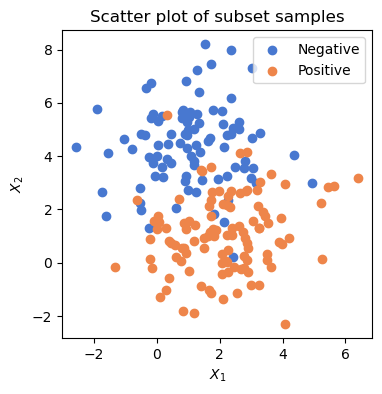

In [5]:
X_sample, y_sample = resample(*(X_train, y_train),replace=False,n_samples=200)
fig = plt.figure(figsize=(4,4))
plt.scatter(X_sample[y_sample==0,0],X_sample[y_sample==0,1],color=colors[0],label="Negative")
plt.scatter(X_sample[y_sample==1,0],X_sample[y_sample==1,1],color=colors[1],label="Positive")
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.title("Scatter plot of subset samples")
plt.legend()

接下来，创建一组基学习器，**包含下面的 3 个模型**

In [6]:
# 用字典存储模型
base_models = {
    "KNN": KNeighborsClassifier(n_neighbors=5), # KNN
    "支持向量机": SVC(C=1.0,kernel="rbf",probability=True), # 支持向量机
    "随机森林": RandomForestClassifier(n_estimators=10,n_jobs=-1,criterion="gini"), # 随机森林
}

再使用GBDT作为元学习器

In [7]:
# 定义元学习器
meta_model = GradientBoostingClassifier(n_estimators=30,learning_rate=0.02,subsample=0.5,max_depth=6)

使用Stacking来训练模型

In [8]:
test_feature, y_test_pred = MyStackingClassifier(X_train,y_train,X_test,base_models,meta_model)

正在处理第 1 折...
正在处理第 2 折...
正在处理第 3 折...
正在处理第 4 折...
正在处理第 5 折...
基学习器 KNN     	 在测试集上的AUC：0.9327
基学习器 支持向量机   	 在测试集上的AUC：0.9362
基学习器 随机森林    	 在测试集上的AUC：0.9337
正在拟合元学习器...


最后来比较**基学习器**和**Stacking模型**在测试集上的表现

In [9]:
for j,name in enumerate(base_models.keys()):
    print("基学习器 %-8s\t 在测试集上的AUC：%.4f"%(name,roc_auc_score(y_test,test_feature[:,j])))
print("Stacking模型在测试集上的AUC：%.4f"%(roc_auc_score(y_test,y_test_pred[:,1])))

基学习器 KNN     	 在测试集上的AUC：0.9251
基学习器 支持向量机   	 在测试集上的AUC：0.9212
基学习器 随机森林    	 在测试集上的AUC：0.9290
Stacking模型在测试集上的AUC：0.9369


可以看到Stacking模型性能有少幅度提升，但提升不多，这就是Stacking所谓的“**榨干模型的最后一丝性能**”

----

## **练习**

1. 比较和总结Bagging。Boosting，XGBoost和LightGBM四个模型，加深自己的理解

2. 学习和使用XGBoost和LightGBM，这两个算法包在**使用时调整超参数是关键**，根据官方提示**总结它们的关键参数有哪些**，应该**如何调整这些参数以获得优秀的模型**？
    * XGBoost官方文档：
        * 中文文档：https://xgboost.apachecn.org/#/README
        * 官方文档：https://xgboost.readthedocs.io/en/latest/
    * LightGBM官方文档：
        * 中文文档：https://lightgbm.cn/
        * 官方文档：https://lightgbm.readthedocs.io/en/latest/index.html

----